**Mô hình dự báo CPI với RF + LSTM + Attention**

In [1]:
!pip install -q pandas numpy scikit-learn tensorflow openpyxl matplotlib seaborn

**Bước 1: Đọc dữ liệu và tiền xử lý**

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler # MinMaxScaler: chuẩn hóa dữ liệu về khoảng [0, 1], giúp mô hình học sâu hoạt động hiệu quả hơn.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer
import tensorflow as tf
import matplotlib.pyplot as plt

# Đọc file Excel
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv('CPI_Data.csv')
df.head() # hiển thị 5 dòng đầu tiên của bảng dữ liệu để bạn kiểm tra nhanh
print(df.head())

# Loại bỏ các dòng chứa giá trị thiếu (NaN) để tránh lỗi khi huấn luyện mô hình
df = df.dropna()
# Dùng cột 'Time' làm chỉ mục thời gian (index) cho bảng dữ liệu — rất quan trọng khi xử lý chuỗi thời gian.\
df.set_index('Time', inplace=True)

# Xử lý dấu phẩy và khoảng trắng, chuyển về float
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(',', '').str.strip()
    df[col] = df[col].astype(float)

# Chuẩn hóa dữ liệu [0, 1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df) # chuẩn hóa tất cả giá trị về khoảng [0, 1] dựa trên giá trị tối thiểu - tối đa của từng cột.

# Gán biến đặc trưng và nhãn
target_col = df.columns.get_loc('CPI')

Saving CPI_Data.csv to CPI_Data.csv
   Time                  GDP                 FDI  Population growth  \
0  2000   31,172,518,403.32    1,298,000,000.00                1.13   
1  2001   32,685,198,808.55    1,300,000,000.00                1.05   
2  2002   35,064,105,500.83    1,400,000,000.00                1.02   
3  2003   39,552,513,231.92    1,450,000,000.00                1.00   
4  2004   45,427,854,693.26    1,610,000,000.00                0.97   

     Population  Unemployment  Lending interest rate  \
0   77,154,011           2.26                  10.55   
1   77,969,361           2.76                   9.42   
2   78,772,224           2.12                   9.06   
3   79,563,777           2.25                   9.48   
4   80,338,971           2.14                   9.72   

   General government final consumption expenditure  \
0                                              6.42   
1                                              6.33   
2                                  

**Bước 2: Lựa chọn đặc trưng bằng Random Forest**

In [14]:
# Tách đặc trưng và nhãn
features = df.drop(columns=['CPI'])
target = df['CPI']

# Huấn luyện mô hình Random Forest
# Tạo một mô hình Random Forest Regressor với 100 cây (n_estimators=100).
# random_state=42: đảm bảo kết quả lặp lại được (tái lập)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(features, target)

# Trích xuất độ quan trọng
importances = rf.feature_importances_
important_indices = np.where(importances > 0.01)[0] # Chọn các đặc trưng có độ quan trọng > 0.01, np.where(...) trả về chỉ số (index) của các cột này.
selected_columns = features.columns[important_indices]
print("Đặc trưng được chọn:", list(selected_columns))

# Tạo tập dữ liệu mới với đặc trưng được chọn
df_selected = df[selected_columns.to_list() + ['CPI']]
scaled_selected = MinMaxScaler().fit_transform(df_selected)


Đặc trưng được chọn: ['GDP', 'FDI', 'Population growth', 'Population', 'Unemployment', 'Lending interest rate', 'General government final consumption expenditure']


**Bước 3: Tạo chuỗi thời gian**

In [16]:
# Chọn các cột đặc trưng quan trọng
selected_cols = ['GDP', 'FDI', 'Population growth', 'Population', 'Unemployment', 'Lending interest rate', 'General government final consumption expenditure', 'CPI']
df_selected = df[selected_cols]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_selected = scaler.fit_transform(df_selected)

# Lấy vị trí của CPI trong danh sách đã chọn
target_col = selected_cols.index('CPI')  # CPI nằm ở cột thứ 3 (index = 3)

# Tạo chuỗi thời gian
def create_sequences(data, target_idx, seq_len=5): # dùng 5 dòng dữ liệu liên tiếp để dự đoán dòng tiếp theo.
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_idx])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(scaled_selected, target_col)

# Chia train/test, 80% dùng để huấn luyện (train), 20% còn lại để kiểm tra (test).
split = int(0.8 * len(X_all))
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]


**Bước 4: Định nghĩa Attention Layer**

In [17]:
class AttentionBlock(Layer):
    def call(self, inputs):
        query = value = inputs
        scores = tf.matmul(query, value, transpose_b=True) # Tính toán ma trận điểm (attention scores),vd  chuỗi dài 5 bước → mỗi điểm có 5 trọng số tương ứng với 5 bước đầu vào
        weights = tf.nn.softmax(scores, axis=-1) #  Tính trọng số attention (softmax), Tổng mỗi hàng = 1 → thể hiện mức độ tập trung vào từng bước thời gian
        context = tf.matmul(weights, value) # Tính ngữ cảnh có trọng số
        return tf.reduce_sum(context, axis=1) # Tổng theo chiều thời gian (axis=1), kết quả còn lại là tensor có shape [batch_size, features].


**Bước 5: Huấn luyện các mô hình**

**RF đơn thuần**

In [18]:
rf_baseline = RandomForestRegressor()
rf_baseline.fit(X_train[:, -1, :], y_train)
rf_preds = rf_baseline.predict(X_test[:, -1, :])


**LSTM đơn**

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input

# Xây dựng mô hình LSTM
model_lstm = Sequential([
    Input(shape=(seq_len, X_train.shape[2])),  # Khai báo input rõ ràng
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

# Biên dịch mô hình
model_lstm.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
model_lstm.fit(X_train, y_train, epochs=200, batch_size=8, verbose=0)

# Dự đoán
y_pred_lstm = model_lstm.predict(X_test).squeeze()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


**LSTM + Attention (không chọn đặc trưng)**

In [21]:
# Tạo chuỗi thời gian đầu vào
X_full, y_full = create_sequences(scaled_data, target_col)
Xf_train, Xf_test = X_full[:split], X_full[split:]
yf_train, yf_test = y_full[:split], y_full[split:]

# Xây dựng mô hình LSTM + Attention bằng Keras Functional API
inputs = Input(shape=(seq_len, Xf_train.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(inputs) # LSTM 64 đơn vị, trả về chuỗi (return_sequences=True) để truyền cho Attention
attention = AttentionBlock()(lstm_out)
output = Dense(1)(attention)

# Compile, huấn luyện và dự đoán
model_att = Model(inputs, output)
model_att.compile(optimizer='adam', loss='mse')
model_att.fit(Xf_train, yf_train, epochs=200, batch_size=8, verbose=0) # Huấn luyện mô hình trong 200 vòng (epoch), Kích thước mỗi batch là 8 mẫu.
y_pred_att = model_att.predict(Xf_test).squeeze()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


**Mô hình đề xuất: RF + LSTM + Attention**

In [22]:
# Lớp Input
inputs_rf = Input(shape=(seq_len, X_train.shape[2]))
# LSTM với trả về chuỗi (return_sequences=True)
lstm_rf = LSTM(64, return_sequences=True)(inputs_rf) # LSTM với 64 đơn vị ẩn (units)
att_rf = AttentionBlock()(lstm_rf)
output_rf = Dense(1)(att_rf) # Lớp đầu ra (Dense)

model_full = Model(inputs_rf, output_rf)
model_full.compile(optimizer='adam', loss='mse')
# Huấn luyện mô hình trong 200 vòng (epoch), batch_size=8: số mẫu được đưa vào mỗi lần cập nhật trọng số
model_full.fit(X_train, y_train, epochs=200, batch_size=8, verbose=0)
y_pred_full = model_full.predict(X_test).squeeze()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


**Bước 6: Đánh giá mô hình**

In [26]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

def evaluate(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # Tính RMSE thủ công
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{name}: RMSE={rmse:.3f}, MAPE={mape*100:.2f}%, R²={r2:.3f}')
    return rmse, mape, r2

# Gọi hàm đánh giá
print("\n--- Đánh giá mô hình ---")
evaluate(y_test, rf_preds, 'Random Forest')
evaluate(y_test, y_pred_lstm, 'LSTM')
evaluate(yf_test, y_pred_att, 'LSTM + Attention (full features)')
evaluate(y_test, y_pred_full, 'Đề xuất: RF + LSTM + Attention')



--- Đánh giá mô hình ---
Random Forest: RMSE=0.184, MAPE=18.54%, R²=-19.876
LSTM: RMSE=0.091, MAPE=8.91%, R²=-4.116
LSTM + Attention (full features): RMSE=0.102, MAPE=11.27%, R²=0.044
Đề xuất: RF + LSTM + Attention: RMSE=0.062, MAPE=6.06%, R²=-1.343


(np.float64(0.06164888453438913), 0.06063946074126343, -1.3428061346663442)

**Về RMSE và MAPE:**

- Mô hình đề xuất (RF + LSTM + Attention) cho kết quả tốt nhất với:

- RMSE = 0.062

- MAPE = 6.06%

--> Sai số rất thấp, mô hình dự báo gần đúng giá trị thực tế.

**Về hệ số xác định R²:**

- R² < 0 ở 3 mô hình (trừ LSTM+Attention full).

-->  mô hình chưa giải thích tốt phương sai của dữ liệu. Có thể do số lượng mẫu nhỏ, biến đầu vào chưa đủ mạnh hoặc mô hình overfit nhẹ.

**Biểu đồ minh họa**

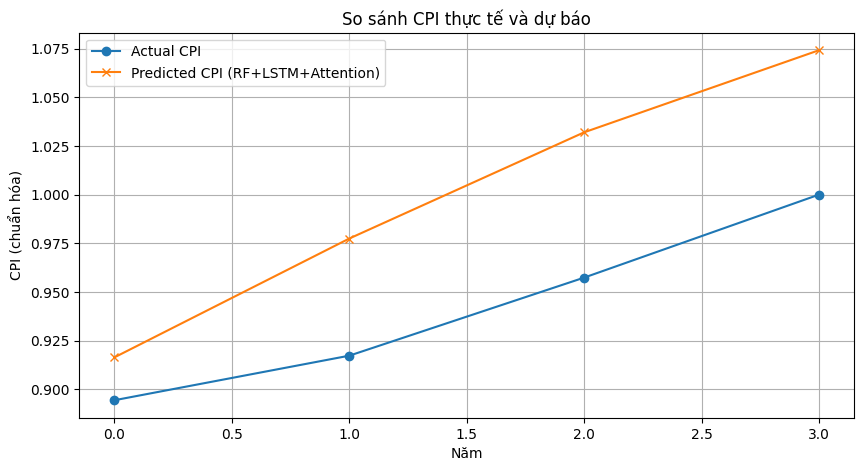

In [27]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual CPI', marker='o')
plt.plot(y_pred_full, label='Predicted CPI (RF+LSTM+Attention)', marker='x')
plt.title('So sánh CPI thực tế và dự báo')
plt.xlabel('Năm')
plt.ylabel('CPI (chuẩn hóa)')
plt.legend()
plt.grid()
plt.show()
